# NER

In [2]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report
import eli5
import scipy.stats
import matplotlib.pyplot as plt

## Dataset
https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv <br>
The dataset has been modified by the 'data_modification.py' script

In [3]:
dframe = pd.read_csv("./data/my_dataset.csv", encoding = "ISO-8859-1", error_bad_lines=True)

In [4]:
dframe

,SentenceN,Word,POS,Tag
0,1,Thousands,NNS,O
1,1,of,IN,O
2,1,demonstrators,NNS,O
3,1,have,VBP,O
4,1,marched,VBN,O
...,...,...,...,...
1048570,47959,they,PRP,O
1048571,47959,responded,VBD,O
1048572,47959,to,TO,O
1048573,47959,the,DT,O


In [5]:
dframe["Tag"].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
print(dframe["Tag"].value_counts())

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


In [7]:
#dframe = dframe[:10000]

In [8]:
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(), 
                                                   s["POS"].values.tolist(),
                                                   s["Tag"].values.tolist())]
grouped = dframe.groupby("SentenceN").apply(agg_func)
sentences = [s for s in grouped]

In [9]:
sentences

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Families', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('soldiers', 'NNS', 'O'),
  ('killed', 'VBN', 'O'),
  ('in', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('conflict', 'NN', 'O'),
  ('joined', 'VBD', 'O'),
  ('the', 'DT', 'O'),
  ('protesters', 'NNS', 'O'),
  ('who', 'WP', 'O'),
  ('carried', 'VBD', 'O'),
  ('banners', 'NNS', 'O'),
  ('with', 'IN', 'O'),
  ('such', 'JJ', 'O'),
  ('slogans', 'NNS', 'O'),
  (

From the book "Speech and Language Processing" by Daniel Jurafsky and James H. Martin 

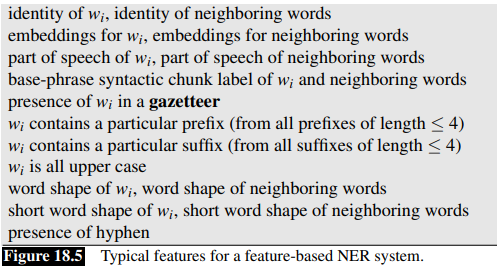 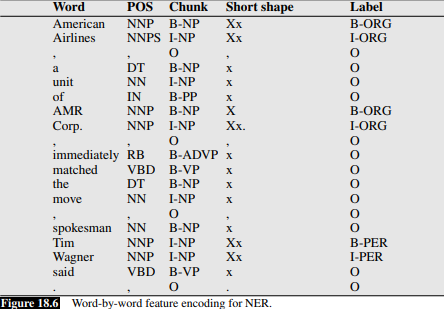

In [10]:
def word_shape(word):
    shape = ""
    for ch in word:
        if ch.isalpha():
            if ch.isupper():
                shape += "X"
            else:
                shape += "x"
        elif ch.isdigit():
            shape += "d"
        else:
            shape += ch
    return shape

def short_word_shape(word):
    shape = ""
    prev = ""
    for ch in word_shape(word):
        if ch != prev:
            shape += ch
            prev = ch
    return shape

def contains_hyphen(word):
    return "-" in word

In [11]:
print(word_shape("I.M.F"))
print(short_word_shape("I.M.F"))
print(contains_hyphen("hello"))

X.X.X
X.X.X
False


In [12]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
        'word_shape()': word_shape(word),
        'short_word_shape()': short_word_shape(word),
        'contains_hyphen()': contains_hyphen(word),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
            '-1:word_shape()': word_shape(word1),
            '-1:short_word_shape()': short_word_shape(word1),
            '-1:contains_hyphen()': contains_hyphen(word1),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
            '+1:word_shape()': word_shape(word1),
            '+1:short_word_shape()': short_word_shape(word1),
            '+1:contains_hyphen()': contains_hyphen(word1),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [13]:
%%time
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Wall time: 15.4 s


In [15]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.24,
    c2=0.13,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Wall time: 4min 6s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.24, c2=0.13,
    keep_tempfiles=None, max_iterations=100)

In [16]:
%%time
y_pred = crf.predict(X_test)

Wall time: 7.5 s


In [17]:
metrics.flat_accuracy_score(y_test, y_pred)

0.9719917494625531

In [18]:
metrics.flat_precision_score(y_test, y_pred, average='weighted')

0.9713891430523243

In [19]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9715110040799858

In [20]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-geo',
 'B-gpe',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-per',
 'I-per',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-gpe',
 'B-art',
 'I-art',
 'I-nat']

In [21]:
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.8518759681995407

In [23]:
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
report = metrics.flat_classification_report(y_test, y_pred, labels=sorted_labels, digits=3)
print(report)

              precision    recall  f1-score   support

       B-art      0.396     0.148     0.216       128
       I-art      0.244     0.095     0.137       105
       B-eve      0.558     0.391     0.460       110
       I-eve      0.400     0.215     0.280        93
       B-geo      0.859     0.910     0.884     12321
       I-geo      0.805     0.798     0.801      2462
       B-gpe      0.971     0.933     0.952      5249
       I-gpe      0.886     0.574     0.696        68
       B-nat      0.649     0.329     0.436        73
       I-nat      0.857     0.286     0.429        21
       B-org      0.811     0.736     0.772      6716
       I-org      0.815     0.793     0.804      5490
       B-per      0.847     0.824     0.835      5616
       I-per      0.843     0.900     0.871      5672
       B-tim      0.934     0.888     0.911      6701
       I-tim      0.842     0.771     0.805      2051

   micro avg      0.861     0.847     0.854     52876
   macro avg      0.732   

In [24]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,2.829,0.164,-3.758,0.192,-3.692,0.783,-7.49,-0.169,-3.173,0.156,-2.457,0.438,-7.497,1.324,-6.777,0.877,-7.232
B-art,-0.417,0.0,6.821,0.0,0.0,0.0,-0.669,-0.147,0.0,0.0,0.0,0.011,-1.629,-0.948,-1.519,-0.071,-0.812
I-art,-0.673,0.0,6.243,0.0,0.0,-0.804,-0.994,-0.367,0.0,0.0,0.0,-0.672,-1.131,0.0,-1.277,-0.575,-0.82
B-eve,-0.703,0.0,0.0,0.0,6.06,-0.489,-0.676,-0.921,0.0,0.0,0.0,-1.066,-1.224,-1.301,-1.276,0.5,-0.841
I-eve,-0.363,0.0,0.0,-1.419,5.778,-0.528,-0.657,-0.252,0.0,0.0,0.0,-0.509,-1.164,-1.159,-1.096,-0.708,-1.059
B-geo,0.407,0.166,-1.332,0.014,-1.526,-3.087,5.376,0.885,-2.157,0.0,-1.007,-0.228,-4.157,-0.755,-3.845,1.295,-3.124
I-geo,-0.189,1.744,-0.614,-0.316,-0.596,-2.03,4.457,-0.582,-1.154,0.0,-0.144,-0.217,-3.063,-0.144,-2.609,0.628,-2.326
B-gpe,0.311,-0.896,-1.787,-1.368,-1.657,-0.005,-3.86,-5.15,4.818,-0.075,-0.139,0.983,-4.488,-0.125,-3.649,-0.449,-2.814
I-gpe,-0.262,0.0,0.0,0.0,0.0,0.0,-0.512,-0.638,4.928,0.0,0.0,-0.474,-0.708,-0.011,-0.589,-0.547,-0.47
B-nat,-0.729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.834,-0.247,-0.329,-0.215,-0.787,-0.002,-0.026


In [27]:
# %%time
# # define fixed parameters and parameters to search
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=labels)

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

In [29]:
# crf = rs.best_estimator_
# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

## Used sources
- https://web.stanford.edu/~jurafsky/slp3/
- https://sklearn-crfsuite.readthedocs.io/en/latest/tutorial.html
- https://eli5.readthedocs.io/en/latest/tutorials/sklearn_crfsuite.html#training-data
- https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/